In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_2.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_7.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_5.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_10.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_1.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_8.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_3.JPG
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_6.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/capsicum/Image_9.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/Image_4.jpg
/kaggle/input/fruit-and-vegetable-image-recognition/validation/sweetcorn/I

## Data loading


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Create a list with the filepaths for training and testing
train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))   # Making list for training dataset

test_dir = Path('../input/fruit-and-vegetable-image-recognition/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))   #Making list for testing dataset

val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))   #Making list for validation dataset

#Function to create labels and concatenate filepath and respective labels
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [4]:
val_df.shape

(334, 2)

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3193

Number of different labels: 36

Labels: ['grapes' 'pear' 'orange' 'spinach' 'potato' 'turnip' 'corn' 'apple'
 'pomegranate' 'mango' 'eggplant' 'sweetcorn' 'tomato' 'sweetpotato'
 'beetroot' 'cucumber' 'cauliflower' 'ginger' 'carrot' 'paprika'
 'capsicum' 'cabbage' 'lettuce' 'garlic' 'raddish' 'jalepeno'
 'bell pepper' 'pineapple' 'soy beans' 'peas' 'onion' 'kiwi' 'lemon'
 'watermelon' 'chilli pepper' 'banana']


In [6]:
train_df

,Filepath,Label
0,../input/fruit-and-vegetable-image-recognition...,grapes
1,../input/fruit-and-vegetable-image-recognition...,pear
2,../input/fruit-and-vegetable-image-recognition...,orange
3,../input/fruit-and-vegetable-image-recognition...,orange
4,../input/fruit-and-vegetable-image-recognition...,spinach
...,...,...
3188,../input/fruit-and-vegetable-image-recognition...,beetroot
3189,../input/fruit-and-vegetable-image-recognition...,spinach
3190,../input/fruit-and-vegetable-image-recognition...,onion
3191,../input/fruit-and-vegetable-image-recognition...,cabbage


In [7]:
a = train_df["Label"].unique() 
a.size

36

## Load the image with image generator

In [8]:
from keras.preprocessing.image import ImageDataGenerator


# loading training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df,
        x_col='Filepath',
        y_col='Label',
        color_mode='rgb',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

Found 3193 validated image filenames belonging to 36 classes.


## Loading testing data

In [9]:
# loading testing data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_dataframe(
        test_df,
        x_col='Filepath',
        y_col='Label',
        color_mode='rgb',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

Found 334 validated image filenames belonging to 36 classes.


## Loading validation data

In [10]:
#loading validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = train_datagen.flow_from_dataframe(
val_df,
x_col='Filepath',
y_col='Label',
color_mode='rgb',
target_size=(64,64),
batch_size=32,
class_mode='categorical')

Found 334 validated image filenames belonging to 36 classes.


## Basic CNN model for multiclass classification

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(64,64,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(36, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        18464     
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 36)                4147236   
Total params: 4,167,492
Trainable params: 4,167,492
Non-trainable params: 0
_________________________________________________________________


In [13]:
#The compilation is the final step in creating a model. ... Once the compilation is done, we can move on to training phase. 
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [14]:
history = model.fit(train_generator,
    validation_data=val_generator,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )])

Epoch 1/5
  5/100 [>.............................] - ETA: 2:44 - loss: 8.6884 - accuracy: 0.0595

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


100/100 [==============================] - 224s 2s/step - loss: 4.5141 - accuracy: 0.0458 - val_loss: 3.2861 - val_accuracy: 0.0898
Epoch 2/5
100/100 [==============================] - 143s 1s/step - loss: 3.2717 - accuracy: 0.1082 - val_loss: 2.8124 - val_accuracy: 0.2665
Epoch 3/5
100/100 [==============================] - 144s 1s/step - loss: 2.9283 - accuracy: 0.1836 - val_loss: 2.3454 - val_accuracy: 0.2964
Epoch 4/5
100/100 [==============================] - 144s 1s/step - loss: 2.6490 - accuracy: 0.2439 - val_loss: 1.9579 - val_accuracy: 0.4431
Epoch 5/5
100/100 [==============================] - 143s 1s/step - loss: 2.4122 - accuracy: 0.3216 - val_loss: 1.6932 - val_accuracy: 0.5329


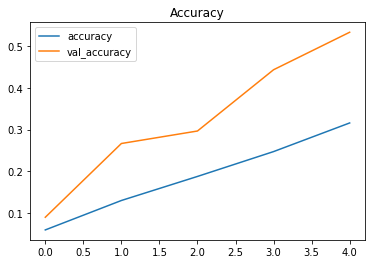

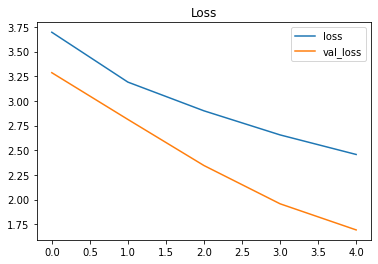

In [15]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

## Now to predict the test set


In [16]:
#predict first 4 images in the test set
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1) #Argmax is most commonly used in machine learning for finding the class with the largest predicted probability

In [17]:
#Mapping the label in y_test for comparing the actual vs predicted
y_test = [labels[k] for k in test_generator.classes]

NameError: name 'labels' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()